In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:

data=np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels=data[:,0]
pixels=data[:,1:]
pixels=pixels/np.max(pixels)

In [ ]:
pixelsT=torch.tensor(pixels,dtype=torch.float32)
labelsT=torch.tensor(labels,dtype=torch.int64)

train_data,test_data,train_labels,test_labels=train_test_split(pixelsT,labelsT,test_size=0.1)

train_dataset=TensorDataset(train_data,train_labels)
test_dataset=TensorDataset(test_data,test_labels)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [ ]:
def create_model():
  class MNISTModel(nn.Module):
    def __init__(self):
      super().__init__()

      self.input_layer=nn.Linear(784,128)
      self.minimize_layer=nn.Linear(128,64)
      self.hidden_layer1=nn.Linear(64,32)
      self.hidden_layer2=nn.Linear(32,32)
      self.output_layer=nn.Linear(32,10)

    def forward(self,x):
      x=F.relu(self.input_layer(x))
      x=F.relu(self.minimize_layer(x))
      x=F.relu(self.hidden_layer1(x))
      x=F.relu(self.hidden_layer2(x))
      return torch.log_softmax(self.output_layer(x), axis=1)
  Model=MNISTModel()
  lossfun=nn.NLLLoss()
  optimizer=torch.optim.SGD(Model.parameters(),lr=0.01)
  return Model,lossfun,optimizer

In [ ]:
Model,lossfun,optimizer=create_model()

X,y=next(iter(train_loader))
loss=lossfun(Model(X),y)


In [ ]:

def train_model():
  numepochs = 70
  net,lossfun,optimizer = create_model()
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  for epochi in range(numepochs):
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )
    trainAcc.append( np.mean(batchAcc) )
    losses[epochi] = np.mean(batchLoss)


  return trainAcc,losses,net


In [7]:
trainAcc,losses,model = train_model()


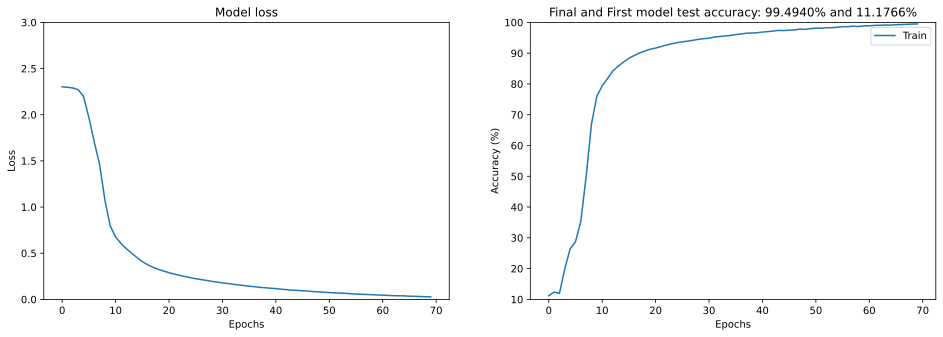

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final and First model test accuracy: {trainAcc[-1]:.4f}% and {trainAcc[0]:.4f}%')
ax[1].legend()

plt.show()

In [ ]:
X,y = next(iter(test_loader))
predictions = torch.exp( model(X).detach())


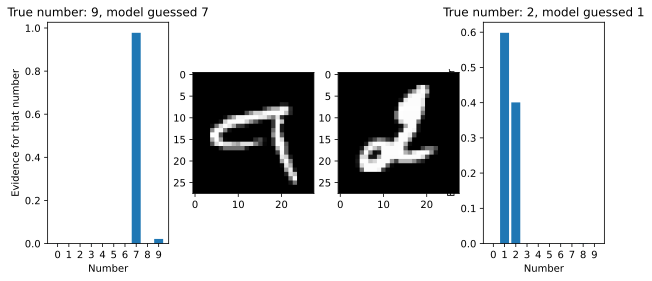

In [ ]:




fig,ax = plt.subplots(1,4,figsize=(10,4))

#Pick out of 2000

index = 178
ax[0].bar(range(10),predictions[index])
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[index].item(), torch.argmax(predictions[index]).item() ))

ax[1].imshow( np.reshape(X[index,:],(28,28)) ,cmap='gray')


# find the errors

sample2show=3
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
ax[3].bar(range(10),predictions[errors[sample2show]])
ax[3].set_xticks(range(10))
ax[3].set_xlabel('Number')
ax[3].set_ylabel('Evidence for that number')
ax[3].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[2].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()